# Preliminary data exploration

## Housekeepin’

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# docs
docs = pd.read_csv("../../data/texts-processed.csv")
docs.head(3)

,Participant,Sector,Country,Year,Language,Link,EconomyType,FileType,FileName,FileTypeMagic,ConversionStatus,ConvertedFileName,OCRStatus,OutputText,OutputFileName
0,AGNI MOTORS,Electronic & Electrical Equ...,India,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,Developing,pdf,0000-2019-agni-motors.pdf,application/pdf,NaN,0000-2019-agni-motors.pdf,0,® AGNI MOTORS ay AN ISO 9001 : 2008 COMPANY Ag...,../../data/text-reports/0000-2019-agni-motors.txt
1,AMBEV S/A,Beverages,Brazil,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,Developing,pdf,0001-2019-ambev-s-a.pdf,application/pdf,NaN,0001-2019-ambev-s-a.pdf,0,SUSTAINABILITY REPORT 2018 “= ( a .) ‘J ambev ...,../../data/text-reports/0001-2019-ambev-s-a.txt
2,Access Spectrum Company Limited,Technology Hardware & Equip...,Myanmar,2019,english,https://ungc-production.s3.us-west-2.amazonaws...,Developing,pdf,0002-2019-access-spectrum-company-limited.pdf,application/pdf,NaN,0002-2019-access-spectrum-company-limited.pdf,0,H.E. ANTONIO GUTERRES Secretary General Unit...,../../data/text-reports/0002-2019-access-spect...


In [14]:
display(docs.shape[0])
display(docs.OutputText.isnull().sum())
docs = docs[docs.OutputText.notnull()]

501

1

In [15]:
docs.Year.value_counts()

2020    351
2019    149
Name: Year, dtype: int64

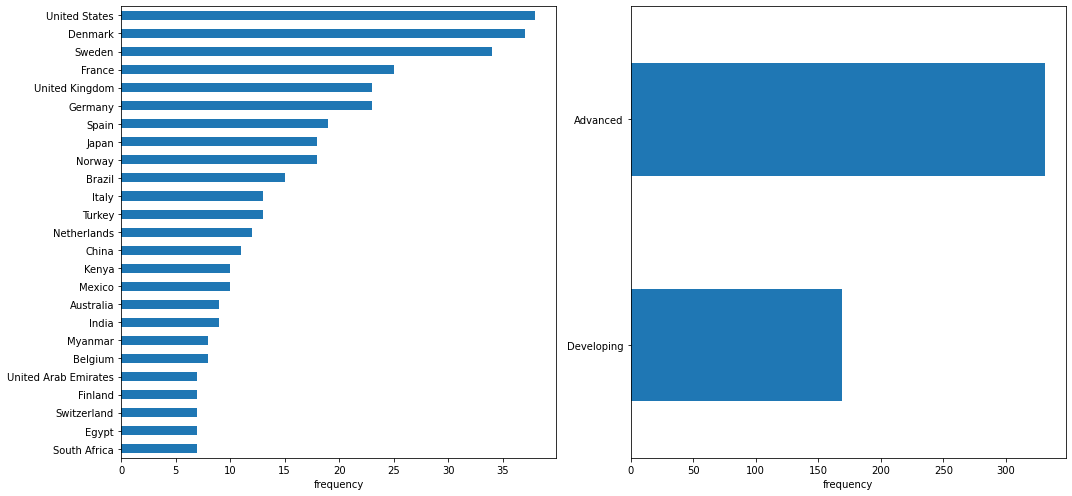

In [16]:
f, axs = plt.subplots(1,2,figsize=(15,7))
dims = ["Country", "EconomyType"]
for i,ax in enumerate(axs):
    dim = dims[i]
    docs_augmented[dim].value_counts().\
        sort_values().tail(25).plot(kind="barh", ax=ax);
    ax.set_xlabel("frequency");
f.tight_layout();    

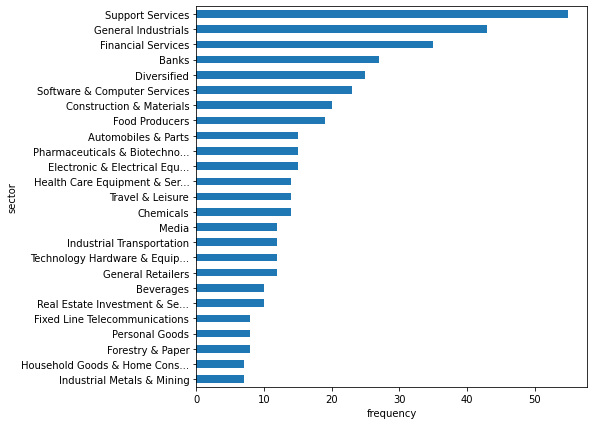

In [17]:
f, ax = plt.subplots(1,1,figsize=(7,7))
docs_augmented.groupby("Sector").Participant.count().\
    sort_values().tail(25).plot(kind="barh", ax=ax);
ax.set_ylabel("sector");
ax.set_xlabel("frequency"); 

In [18]:
# avg documents per participant, possible concat?
docs_augmented.Participant.value_counts().mean()

1.0309278350515463

## Texts

In [19]:
def purge_chars(text):
    import re
    
    text = text.lower()
    text = re.sub(r"<.*?>|</.*?>","",text)
    text = re.sub(r"(s?)(f|ht)tp(s?)://\S+\b","",text)
    text = re.sub(r"^[a-z0-9]+[\._]?[a-z0-9]+[@]\w+[.]\w{2,3}$","", text) #email
    text = re.sub(r"\\-","", text)
    text = re.sub("[^a-z '.,?!:]"," ",text)
    text = re.sub(r"\b(\w+\s*)\1{1,}", " ",text) #dupli "\\1"
    return re.sub(r" +"," ",text)

docs_augmented["OutputChars"] = docs_augmented.apply(lambda x: purge_chars(x.OutputText), axis=1)    

In [20]:
# chars, no of tokens, no of sentences, languages
import fasttext as fs
ftm = fs.load_model("../../data/lid.176.bin")
def get_characteristics(df, ftm=ftm):
    import re
    import pandas as pd
    string = df.OutputChars
    df["n_chars"] = len(string)
    df["n_words"] = len(re.split("\w+",string))
    df["n_sents"] = len(re.split("[.!?]", string))
    lest = ftm.predict(string, k=1)
    df["lang_est"] = lest[0][0].split("_")[-1]
    df["lang_est_conf"] = lest[1][0]
    return df
docs_augmented = docs_augmented.apply(get_characteristics, axis=1)    

In [21]:
docs_augmented.n_words.describe()

count       500.000000
mean      11598.104000
std       16653.455935
min          35.000000
25%        1905.000000
50%        4818.000000
75%       14526.750000
max      111601.000000
Name: n_words, dtype: float64

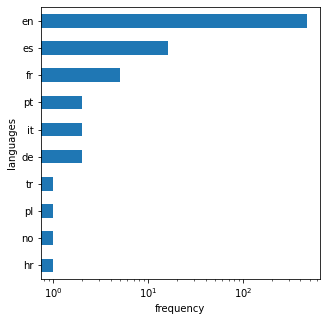

In [22]:
f, ax = plt.subplots(1,1,figsize=(5,5))
docs_augmented.groupby("lang_est").Participant.count().\
    sort_values().tail(25).plot(kind="barh", ax=ax, logx=True);
ax.set_ylabel("languages");
ax.set_xlabel("frequency"); 

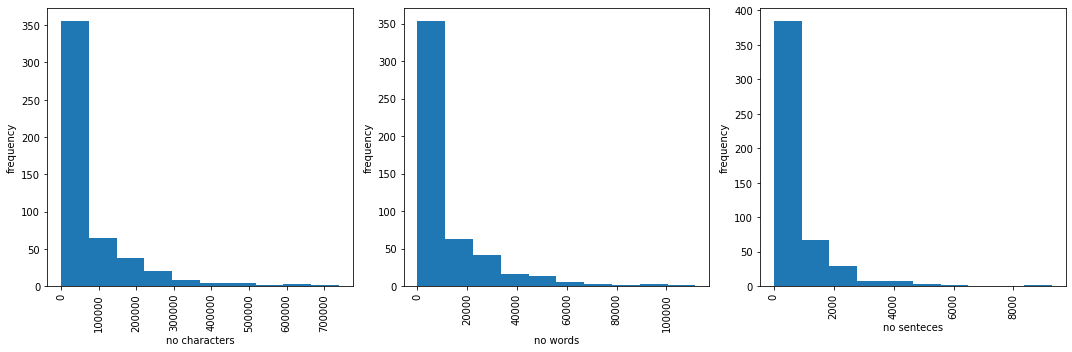

In [23]:
# plot it
f, axs = plt.subplots(1,3,figsize=(15,5))
counts = {"n_chars":"no characters", "n_words":"no words", "n_sents":"no senteces"}
for c, ax in zip(counts.keys(), axs.flatten()):
    docs_augmented[c].plot(kind="hist", ax=ax, rot=90);
    ax.set_ylabel("frequency");
    ax.set_xlabel(counts[c]);
f.tight_layout();

In [24]:
docs_augmented = docs_augmented[(docs_augmented.lang_est=="en") & (docs_augmented.lang_est_conf>0.8) & (docs_augmented.n_chars>=1000)]

In [47]:
# duplicate cleanup using vector embeddings
def get_sim(row):
    import spacy
    #spacy.require_gpu()
    nlp =  spacy.load("en_core_web_lg")
    #nlp.max_length = 1000000
    d1, d2 = nlp(row["ft"]), nlp(row["tt"])
    sim =  d1.similarity(d2)
    return sim

agp = docs_augmented.Participant.value_counts().sort_values()
di = docs_augmented.index[[p in set(agp.index[agp>1]) for p in docs_augmented.Participant]]
di_map = pd.DataFrame(list(product(di, di)), columns=["f", "t"])
di_map = di_map[di_map.f>di_map.t]
di_map["fn"] = docs_augmented.loc[di_map.f].Participant.values
di_map["tn"] = docs_augmented.loc[di_map.t.values].Participant.values
di_map["ft"] = docs_augmented.loc[di_map.f.values].OutputChars.values
di_map["tt"] = docs_augmented.loc[di_map.t.values].OutputChars.values
di_map =  di_map[di_map.fn==di_map.tn].reset_index(drop=True)
di_map["similarity"] = di_map.apply(get_sim, axis=1)
fi = [i for i in docs_augmented.index if i not in set(di)] + \
    [r[1]["f"] for r in di_map.iterrows() if r[1]["similarity"]>=.97]
docs_deduplicated = docs_augmented.loc[list(set(fi))]

di_map[di_map.similarity>.94].sort_values("similarity").head()

,f,t,fn,tn,ft,tt,similarity
14,451,20,Biotage AB,Biotage AB,communication on progress biotage statement of...,"s , biotage in brief message from the ceo r s...",0.973121
5,251,4,Ahlsell AB,Ahlsell AB,ie . j pie . ute was eo te f i rt 's f fl ay ...,code of conduct owner: approved by: approval d...,0.977674
11,436,435,Bens Electronics Services Ltd,Bens Electronics Services Ltd,bens electronics services og statement of comm...,"r vf a . pe on progress p vf j, a of statement...",0.996091
4,233,232,"Advanced Labelworx, Inc.","Advanced Labelworx, Inc.","advanced labelworx, inc. global compact commun...","advanced labelworx, inc. global compact commun...",0.996541
1,187,1,AMBEV S/A,AMBEV S/A,sustainability report . a powmttiun : ns : a ...,sustainability report a . j ambev : f a we ell...,0.997882


In [48]:
def concat_docs(df):
    rd = {}
    rd["index"] = np.min(df.index)
    rd["OutputChars"] = " ".join(df["OutputChars"])
    return pd.Series(rd, index=rd.keys())

sf = di_map.similarity<0.94

coni = pd.concat([di_map[sf].f, di_map[sf].t]).reset_index(drop=True).values
if len(coni)>0:
    dg = docs_augmented.loc[coni].groupby("Participant", as_index=False).apply(concat_docs).set_index("index")
else:
    dg = pd.DataFrame(columns=["Participant", "OutputChars"])
docs_deduplicated = docs_deduplicated.append(
    dg.merge(docs_augmented.loc[:,[c for c in docs_augmented.columns if c not in set(dg.columns)]],
    left_index=True, right_index=True))

In [49]:
docs_deduplicated.loc[264]

Participant                                               Akritas S.A.
Sector                                                Forestry & Paper
Country                                                         Greece
Year                                                              2020
Language                                                       english
Link                 https://ungc-production.s3.us-west-2.amazonaws...
EconomyType                                                   Advanced
FileType                                                           pdf
FileName                                     0264-2020-akritas-s-a.pdf
FileTypeMagic                                          application/pdf
ConversionStatus                                                   NaN
ConvertedFileName                            0264-2020-akritas-s-a.pdf
OCRStatus                                                            0
OutputText           n q3 AKRITAS COMMUNICATION ON PROGRESS 2018 ——...
Output

In [ ]:
#  the most frequent tokens
from sklearn.feature_extraction.text import CountVectorizer
tokvec = CountVectorizer(max_features=25, stop_words="english",
    min_df=50)
token_counts = tokvec.fit_transform(docs_deduplicated.OutputChars)
f, ax = plt.subplots(1,1,figsize=(7,7))
pd.DataFrame(token_counts.toarray(), columns=tokvec.get_feature_names()).\
    sum().sort_values().plot(kind="barh", ax=ax, logx=True);
ax.set_ylabel("tokens");
ax.set_xlabel("freq"); 

In [ ]:
import gc
del tokvec, token_counts
gc.collect()

In [ ]:
# 1,2,3-grams
gramvec = CountVectorizer(ngram_range=(1,3), stop_words="english",
   min_df=50, max_features=5000)
gram_counts = gramvec.fit_transform(docs_augmented.OutputChars)
gram_counts = pd.DataFrame(gram_counts.todense(),
    columns=gramvec.get_feature_names())
gram_counts = gram_counts.sum().reset_index()
gram_counts.columns = ["ngram", "frequency"]
gram_counts["n"] = gram_counts.ngram.apply(lambda x: len(x.split(" ")))

f, axs = plt.subplots(1,3,figsize=(15,5))
for ax, n in zip(axs, gram_counts.n.unique()):
    gram_counts[gram_counts.n==n].sort_values("frequency").tail(15).\
        plot(y="frequency",x="ngram", kind="barh", ax=ax, legend="false",
        logx=True)
    ax.set_title(str(n)+"-gram");
    ax.set_ylabel("");
    ax.set_xlabel("frequency");
    ax.get_legend().remove();
f.tight_layout()  

In [ ]:
del gramvec, gram_counts
gc.collect()

In [ ]:
# upos
def get_upos(text,i):
    import spacy
    
    nlp =  spacy.load("en_core_web_lg")
    nlp.max_length = 1600000
    parsed = nlp(text)
    ls = [(i, t.text, t.lemma_, t.pos_, t.tag_, t.dep_,
    t.shape_, t.is_alpha, t.is_stop) for t in parsed]
    return pd.DataFrame(ls,
        columns=["doc_id","text", "lemma", "pos", "tag",
            "dep", "shape", "is_alpha", "is_stopword"])

from joblib import Parallel, delayed
upos_ls = Parallel(n_jobs=6)(delayed(get_upos)(docs_augmented.OutputChars.loc[i],i)\
    for i in docs_augmented.index)
docs_upos = pd.concat(upos_ls)

# common ones
docs_upos.pos.value_counts().sort_values().tail(5)

In [ ]:
# barh noun, verb, adj
upos_subset = ["NOUN", "VERB","ADJ"]
f, axs = plt.subplots(1,3,figsize=(17,5))
for ax, up in zip(axs, upos_subset):
    docs_upos[docs_upos.pos==up].lemma.value_counts().sort_values().tail(15).\
        plot(kind="barh", ax=ax, legend="false")
    ax.set_title(up)
    ax.set_xlabel("frequency");
    ax.get_legend().remove()
f.tight_layout()

In [ ]:
uf = (docs_upos.pos.isin(["NOUN", "VERB", "ADJ"])) & (np.logical_not(docs_upos.is_stopword)) & (docs_upos.lemma.str.len()>2) &\
    (docs_upos.text.str.len()<51)
docs_reconstructed = docs_upos[uf].groupby("doc_id").\
    apply(lambda x: " ".join(x["lemma"]))
docs_reconstructed=docs_deduplicated.merge(pd.DataFrame(docs_reconstructed,
    columns=["ReconstructedChars"]), how="inner", left_index=True, right_index=True)
del docs_deduplicated, docs_upos
gc.collect()

In [ ]:
docs_reconstructed.to_csv("../../data/docs-reconstructed.csv")
docs_reconstructed.head(5)

In [ ]:
# rake - example
import spacy
from rake_spacy import Rake
def filter_tokens(token):
    return (token.is_stop or token.is_space or token.is_punct) and not (token.like_num)\
        and (token.pos_ not in ["ADJ", "VERB", "NOUN"]) and (len(token.text)<2)
rake = Rake(nlp=spacy.load("en_core_web_lg"), min_length=2, max_length=5,
    stop_token_class=filter_tokens)
rake.apply(docs_augmented.OutputChars[0])[:10]

In [ ]:
# coocurence
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
coovec = TfidfVectorizer(stop_words="english",
    ngram_range=(1,1), max_features=1000)
coo_w = coovec.fit_transform(docs_reconstructed.ReconstructedChars)
tokens = coovec.get_feature_names()
#coo_f[coo_f>0]=1
coo_w = coo_w.T.dot(coo_w)
coo_w = np.triu(coo_w.todense(), k=1)
from itertools import combinations
edges = list(combinations(range(coo_w.shape[0]),2))
ind0, ind1 = [e[0] for e in edges], [e[1] for e in edges]
freq = coo_w[ind0,ind1]
coo_counts = pd.DataFrame(columns=["from", "to", "weight"])
coo_counts["from"], coo_counts["to"]  = [tokens[i]for i in ind0], [tokens[i]for i in ind1]
coo_counts["weight"] = freq
coo_counts.sort_values("weight").tail(15)

In [ ]:
# networkx
import networkx as nx
net = nx.convert_matrix.from_pandas_edgelist(coo_counts.sort_values("weight").tail(100),
    source="from", target="to", edge_attr="weight")
f,ax = plt.subplots(1,1,figsize=(15, 10))
pos = nx.spring_layout(net, seed=1, iterations=100)
nx.draw_networkx_labels(net, pos, font_size=12,
    font_family="sans-serif", alpha=1, ax=ax);
nx.draw_networkx_edges(net, width=[net[u][v]['weight']*.5 for u,v in net.edges()],
    pos=pos, alpha=.1);

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
            fontdict={'fontsize': 12})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=14)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# lda topics
from sklearn.decomposition import LatentDirichletAllocation
dims = ["Advanced", "Developing"]

for dim in dims:
    df = docs_reconstructed.EconomyType==dim
    tfidfvec = TfidfVectorizer(min_df=50, max_features=5000)
    tfidf_counts = tfidfvec.fit_transform(docs_reconstructed[df].ReconstructedChars)
    lda = LatentDirichletAllocation(n_components=15, max_iter=10,
        learning_method='online', learning_offset=50., random_state=0)
    lda.fit(tfidf_counts)
    plot_top_words(lda, tfidfvec.get_feature_names(), 5, "Topics in LDA model: "+dim.lower()+" economies")